<a href="https://colab.research.google.com/github/Himagination/NLP_Transformers/blob/main/Customer_Review_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# GPU information
!nvidia-smi

Wed Mar 16 09:43:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Customer Review Classification

- Data set provided has a mix of customer reviews for products across categories and retailers.
- Model on the data to bucket the future reviews in their respective topics (Note: A review can talk about multiple topics) and Overall polarity (positive/negative sentiment): 
  - Topics (Components, Delivery and Customer Support, Design and Aesthetics, Dimensions, Features, Functionality, Installation, Material, Price, Quality and Usability)
  - Polarity (Positive/Negative)

- Details on Input and Target Variables:

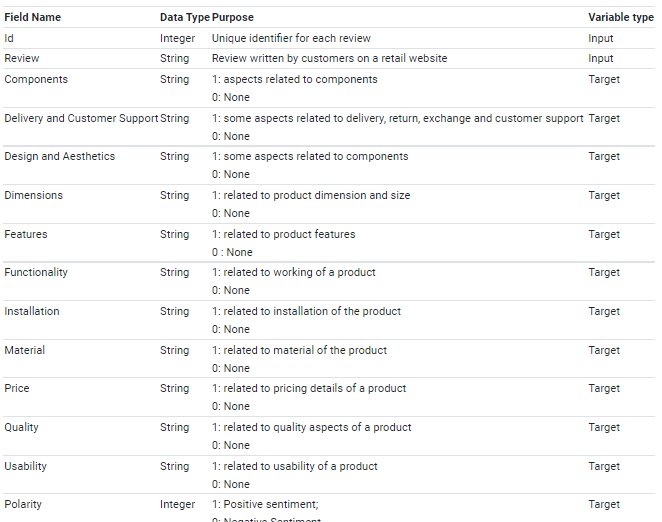

# Approach

- It's a typical problem of Multi-Label Text Classification where the Customer reviews can be categorised in one or more categories.
- There can be multiple approaches to tackle such a problem varying from Statistical NLP, Classical Machine Learning to Modern day Transformers.
- In this notebook, the main focus will be Transformers. However, some Classic Machine Learning Methods will be carried on to show the difference of Performance.
- Undoubtedly, for any machine learning project, Exploratory Data Analysis is best practise to begin with, as it let's the practitioner to become one with the data which as per me is the most crucial step. However, after the advent of the Transformers, preprocessing text data has been reduced as pretrained tokenizers of existing Transformers Architecture are sufficient. However, in this notebook Exploratory Data Analysis will be performed first.
- Section 1: Exploratory Data Analysis.
- Section 2: Multi-Label Text Classification using Classical Machine Learning Models.**(Using Sklearn)**
- Section 3: Multi-Label text Classification using **BERT(Bidirectional Encoder Representations from Transformers)** on raw data.
  - For transformers, **HuggingFace** platform will be used.
  - For coding framework, **PyTorch Lightning**.



# Section 0: The DATA

- DATA provided is in a csv file *train.csv*, and is stored on Google Drive.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
# Download the data from Google Drive
!gdown --id 1f91IVH5DHkKkUzmMv4z5rX_5z6Bn9uOo

Downloading...
From: https://drive.google.com/uc?id=1f91IVH5DHkKkUzmMv4z5rX_5z6Bn9uOo
To: /content/train.csv
100% 1.18M/1.18M [00:00<00:00, 140MB/s]


In [4]:
# Store data as pandas DataFrame
cust_rev_df = pd.read_csv("train.csv", index_col="Id")
cust_rev_df.head()

,Review,Components,Delivery and Customer Support,Design and Aesthetics,Dimensions,Features,Functionality,Installation,Material,Price,Quality,Usability,Polarity
Id,,,,,,,,,,,,,
0,For some reason everybody complains and I'm co...,0,0,0,0,0,0,0,0,0,0,1,0
1,"I like everything about it, great choice of sp...",0,0,0,0,1,1,0,0,0,0,0,1
2,Excellent ceiling fan brace. Easy to install a...,0,0,0,0,0,0,1,0,0,1,0,1
3,Work great easy to use . No issues at all with...,0,0,0,0,0,1,0,0,0,0,1,1
4,I would recommend this product because it is p...,0,0,0,0,0,0,0,0,0,1,0,1


In [5]:
# Split data into train, validation and test set
train_df, test_df = train_test_split(cust_rev_df, test_size=0.05)
train_df, val_df = train_test_split(train_df, test_size=0.05)
train_df.shape, val_df.shape, test_df.shape

((5537, 13), (292, 13), (307, 13))

In [7]:
LABEL_COLUMNS = cust_rev_df.columns[1:].to_list()
LABEL_COLUMNS

['Components',
 'Delivery and Customer Support',
 'Design and Aesthetics',
 'Dimensions',
 'Features',
 'Functionality',
 'Installation',
 'Material',
 'Price',
 'Quality',
 'Usability',
 'Polarity']

# Section 1: Exploratory Data Analysis

## Import required packages.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes as ax
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotnine import *
from matplotlib_venn import venn3, venn3_circles
import re
import logging
import itertools
import unicodedata
import string
import nltk
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import spacy
nlp = spacy.load('en_core_web_sm')
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from IPython.display import Markdown as md
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


First, let's check if any review is without any labels and also, let's visualize the distribution of reviews for different labels.

In [10]:
# Check if any review doesn't belong to any of the categories.
plt.style.use("seaborn-pastel")
def category_percentage(df):
    df['Without_Label'] = np.where((df['Components']==0) &
                                   (df['Delivery and Customer Support']==0) & 
                                   (df['Design and Aesthetics']==0) &
                                   (df['Dimensions']==0) &
                                   (df['Features']==0) &
                                   (df['Functionality']==0) &
                                   (df['Installation']==0) &
                                   (df['Material']==0) &
                                   (df['Price']==0) &
                                   (df['Quality']==0) & 
                                   (df['Usability']==0), 1,0)
    
    labels = df.columns.tolist()[1:]
    plot_data = df[labels].mean()*100

    plt.figure(figsize=(20,8))
    plt.title("percentage records by label_columns")
    sns.barplot(x=plot_data.index, y = plot_data.values)
    plt.show()

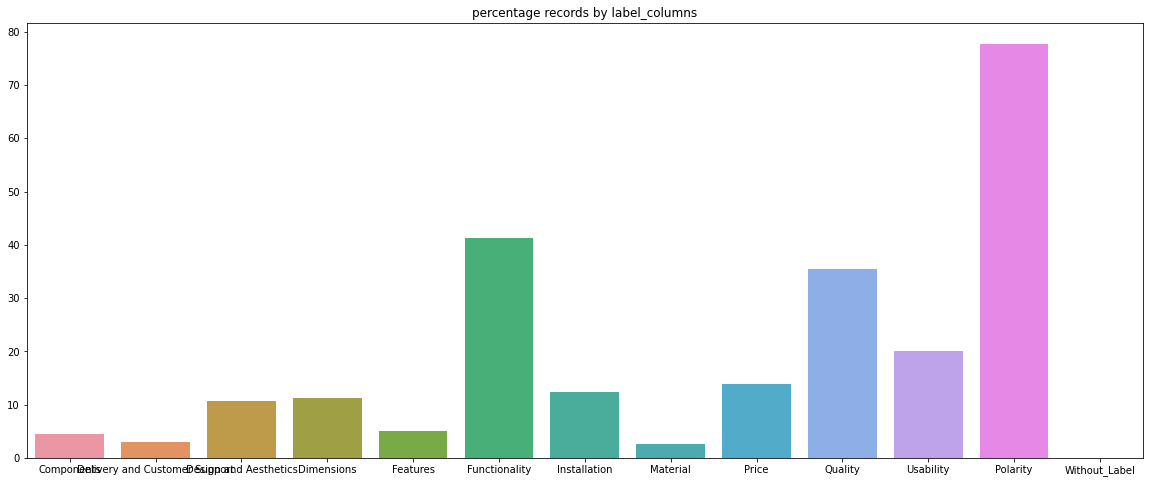

In [11]:
category_percentage(cust_rev_df)

- There are two notable points from above plot:
  - First, there are no reviews without any labels.
  - Second, Although we can see that the class distributions are not uniform, and ideally in such a case, sampling should be performed, however as the skewness is not predominant, we can avoid sampling our small dataset.

In [16]:
# Remove Without_Label column
cust_rev_df.drop(["Without_Label"], axis=1, inplace=True)

### Meta Data Analysis

In [60]:
def meta_data_analysis(df, text_col):
    meta_df = pd.DataFrame()
    meta_df['punctuations'] = df[text_col].apply(lambda x : len([a for a in str(x) if a in string.punctuation]))
    meta_df['hashtags'] = df[text_col].apply(lambda x : len([a for a in x.split() if a.startswith("#")]))
    meta_df['usernames'] = df[text_col].apply(lambda x : len([a for a in x.split() if a.startswith("@")]))
    meta_df['stop_words'] = df[text_col].apply(lambda x : len([a for a in x.lower().split() if a in STOPWORDS]))
    meta_df['upper_case_words'] = df[text_col].apply(lambda x : len([a for a in x.split() if a.isupper()]))
    meta_df['urls'] = df[text_col].apply(lambda x : len([a for a in x.split() if a.startswith(tuple(['http', 'www']))]))
    meta_df['word_count'] = df[text_col].apply(lambda x : len(x.split()))
    meta_df['distinct_word_count'] = df[text_col].apply(lambda x : len(set(x.split())))    
    return meta_df

In [62]:
meta_df = meta_data_analysis(cust_rev_df, "Review")
meta_df.sum()

punctuations            25800
hashtags                   16
usernames                   1
stop_words              87249
upper_case_words         6062
urls                        2
word_count             184132
distinct_word_count    153606
dtype: int64

In [41]:
class ReviewTextCleaning:

  @staticmethod
  def expand_contractions(review_text):
    return contractions.fix(review_text)

  cleaning_regex_map = {
        'web_links': r'(?i)(?:(?:http(?:s)?:)|(?:www\.))\S+',
        'email': r'[\w.]+@\w+\.[a-z]{3}',
        'twitter_handles': r'[#@]\S+',
        'redundant_newlines': r'[\r|\n|\r\n]+',
        'redundant_spaces': r'\s\s+',
        'punctuations': r'[\.,!?;:]+',
        'special_chars': r'[^a-zA-Z\s\.,!?;:]+'
        }
  @staticmethod
  def clean_text_from_regex(review_text, text_clean_regex):
    '''
    Follow a particular cleaning expression, provided
    as an input by an user to clean the text.
    '''
    return text_clean_regex.sub(' ', review_text).strip()

  @staticmethod
  def remove_web_links(review_text):
    web_links_regex = re.compile(ReviewTextCleaning.cleaning_regex_map['web_links'])
    return ReviewTextCleaning.clean_text_from_regex(review_text, web_links_regex)

  @staticmethod
  def remove_email_addresses(review_text):
    email_regex = re.compile(ReviewTextCleaning.cleaning_regex_map['email'])
    return ReviewTextCleaning.clean_text_from_regex(review_text, email_regex)

  @staticmethod
  def remove_twitter_handles(review_text):
     twitter_handles_regex = re.compile(ReviewTextCleaning.cleaning_regex_map['twitter_handles'])
     return ReviewTextCleaning.clean_text_from_regex(review_text, twitter_handles_regex)

  @staticmethod
  def remove_redundant_newlines(review_text):
    redundant_newlines_regex = re.compile(
            ReviewTextCleaning.cleaning_regex_map['redundant_newlines'])
    return ReviewTextCleaning.clean_text_from_regex(review_text, redundant_newlines_regex)

  @staticmethod
  def remove_redundant_spaces(review_text):
    redundant_spaces_regex = re.compile(
            ReviewTextCleaning.cleaning_regex_map['redundant_spaces'])
    return ReviewTextCleaning.clean_text_from_regex(review_text, redundant_spaces_regex)

  @staticmethod
  def remove_punctuations(review_text):
    remove_punctuations_regex = re.compile(ReviewTextCleaning.cleaning_regex_map['punctuations'])
    return ReviewTextCleaning.clean_text_from_regex(review_text, remove_punctuations_regex)

  @staticmethod
  def remove_special_chars(review_text):
    special_chars_regex = re.compile(ReviewTextCleaning.cleaning_regex_map['special_chars'])
    return ReviewTextCleaning.clean_text_from_regex(review_text, special_chars_regex)

**Let's clean the dataset.**

In [ ]:
def clean_data(df,col_to_clean):
    df[col_to_clean] = df[col_to_clean].apply(ReviewTextCleaning.remove_web_links)
    df[col_to_clean] = df[col_to_clean].apply(ReviewTextCleaning.remove_email_addresses)
    df[col_to_clean] = df[col_to_clean].apply(ReviewTextCleaning.remove_twitter_handles)
    df[col_to_clean] = df[col_to_clean].apply(ReviewTextCleaning.expand_contractions)
    df[col_to_clean] = df[col_to_clean].apply(ReviewTextCleaning.remove_special_chars)
    df[col_to_clean] = df[col_to_clean].apply(ReviewTextCleaning.remove_redundant_spaces)
    df[col_to_clean] = df[col_to_clean].apply(ReviewTextCleaning.remove_punctuations)

    return df

Let's check the text lengths of reviews across all classes.

In [24]:
def text_length_across_classes(df):
    df['review_length'] = df['Review'].apply(lambda x : len(x.split()))
    
    median_text_len = []
    mean_text_len = []
    min_text_len = []
    max_text_len = []
    max_distinct_tokens = []
    
    for i in LABEL_COLUMNS:
        mean_text_len.append(df[df[i]==1]['review_length'].mean())  
        min_text_len.append(df[df[i]==1]['review_length'].min())  
        max_text_len.append(df[df[i]==1]['review_length'].max())  
        median_text_len.append(df[df[i]==1]['review_length'].median())  
        df['distinct_tokens'] = df['Review'].apply(lambda x : len(set(x.split())))
        max_distinct_tokens.append(df[df[i]==1]['distinct_tokens'].max())
    
    fig, axes = plt.subplots(2, 2, figsize=(24, 12))
    sns.barplot(ax=axes[0,0], x=LABEL_COLUMNS, 
                y=median_text_len).tick_params(axis='x', rotation=45)
    axes[0,0].set_title('median text length')
    sns.barplot(ax=axes[0,1], x=LABEL_COLUMNS, 
                y=min_text_len).tick_params(axis='x', rotation=45)
    axes[0,1].set_title('minimum text length')
    sns.barplot(ax=axes[1,0], x=LABEL_COLUMNS, 
                y=max_text_len).tick_params(axis='x', rotation=45)
    axes[1,0].set_title('max text length')
    sns.barplot(ax=axes[1,1], x=LABEL_COLUMNS, 
                y=max_distinct_tokens).tick_params(axis='x', rotation=45)
    axes[1,1].set_title('max distinct tokens')
    fig.suptitle('text length statistics')
    plt.show()

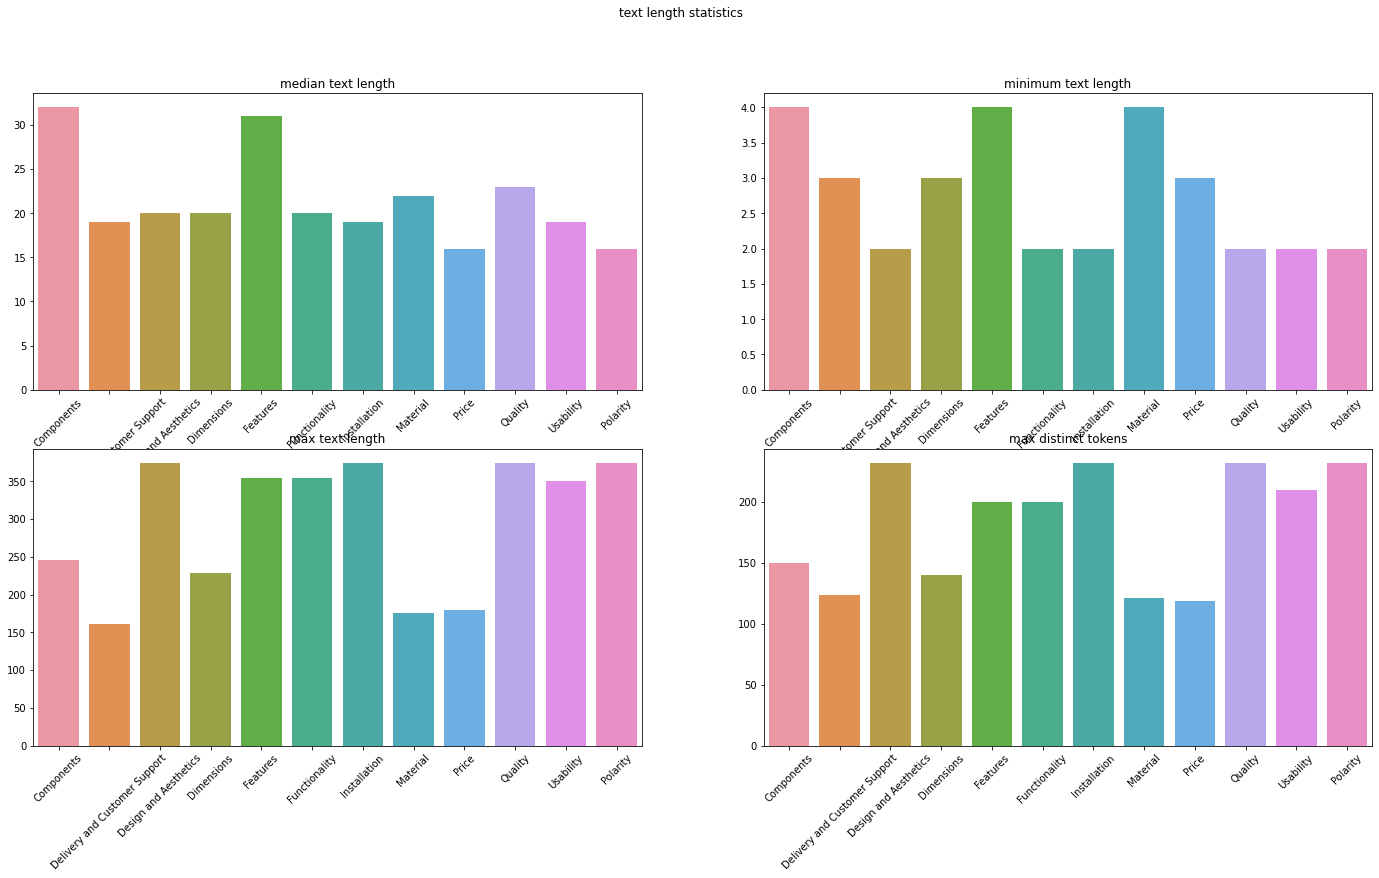

In [25]:
text_length_across_classes(cust_rev_df)

From above plot, we note the maximum text length which is around 400 and maximum distinct token size is around 250. This might suggest presence of repetitive words.
This will also be useful as pretrained NLP Tokenizer has their design value for the same.

Also, let's quickly check the distribution of text length.

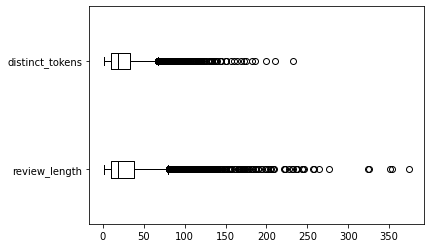

In [31]:
cust_rev_df.boxplot(["review_length", "distinct_tokens"], grid=False, color="black", vert=False)

Above plot shows that most of the reviews have text length below 100, while there are few outliers above 300. We could remove them from training dataset and consider only those reviews whose length is below 100 to make our training faster. But for this notebook, the same will not be performed. 

In [42]:
def avg_word_len_plot(df):
  df['avg_word_length'] = df['Review'].apply(lambda x : np.round(np.mean([len(a) for a in x.split()])))
  reviews = df.avg_word_length.value_counts().reset_index()
  reviews.columns = ['length', 'frequency']
  print(f"reviews max token length : {(max(reviews.length))}")
  toxic = reviews.sort_values(by='length')
  plt.figure(figsize=(20,7))
  plt.title("Average word length")
  sns.barplot(x=reviews.length, y=reviews.frequency)
  plt.xticks(rotation = 90)
  plt.show()

reviews max token length : 12.0


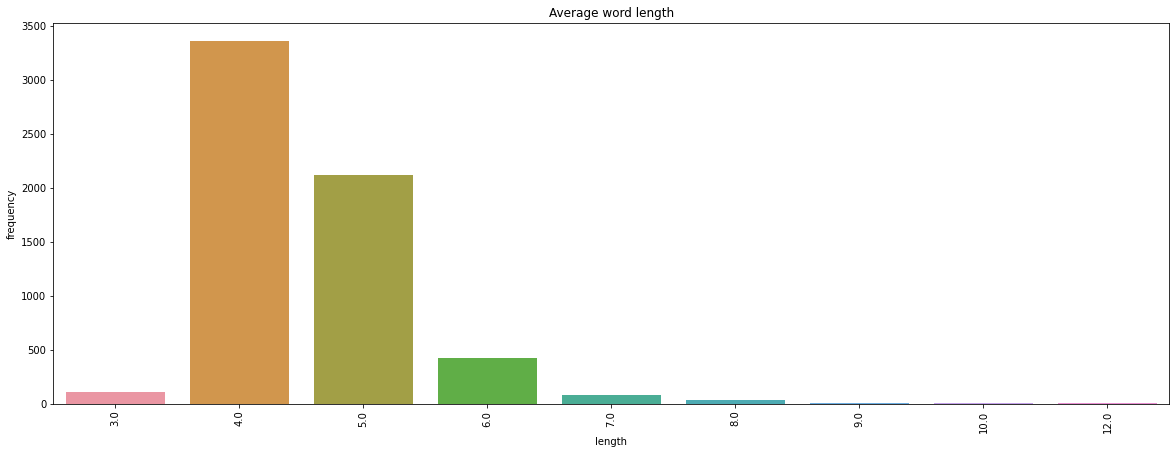

In [43]:
avg_word_len_plot(cust_rev_df)

**The word length looks fine. There is no word with unusual length. So, we can move ahead.**

Now, let's check correlation between labels.

In [32]:
def corr_between_labels(df):
    plt.figure(figsize=(15,8))
    plt.title("correlation between Customer review categories")
    sns.heatmap(df.corr(),cmap='YlGnBu',annot=True)
    plt.show()
    return

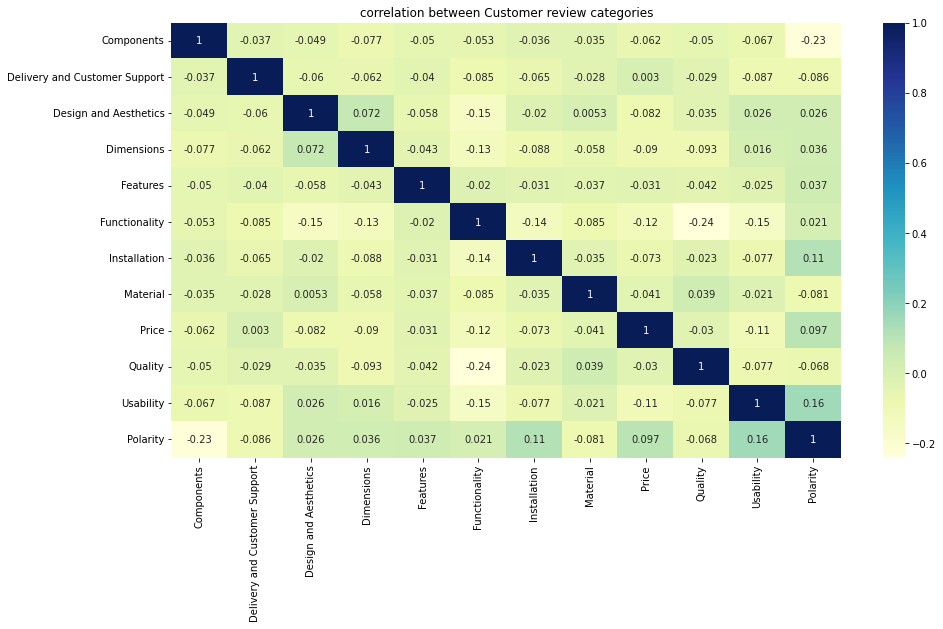

In [34]:
corr_between_labels(cust_rev_df[LABEL_COLUMNS])

There is no evident correlation between any categories from above plot.

In [46]:
def generate_wordclouds(df):
    category_text = df["Review"].values              
    plt.figure(figsize=(15,8))
    wc = WordCloud(background_color="black", 
                   max_words=5000, 
                   stopwords=STOPWORDS, 
                   collocations=False,
                   max_font_size= 40)
    wc.generate(" ".join(category_text))
    plt.title("Word Cloud of Customer Reviews")
    plt.imshow(wc.recolor(colormap='Pastel2', random_state=31415926), alpha=0.98)
    plt.axis('off')    
    plt.show()

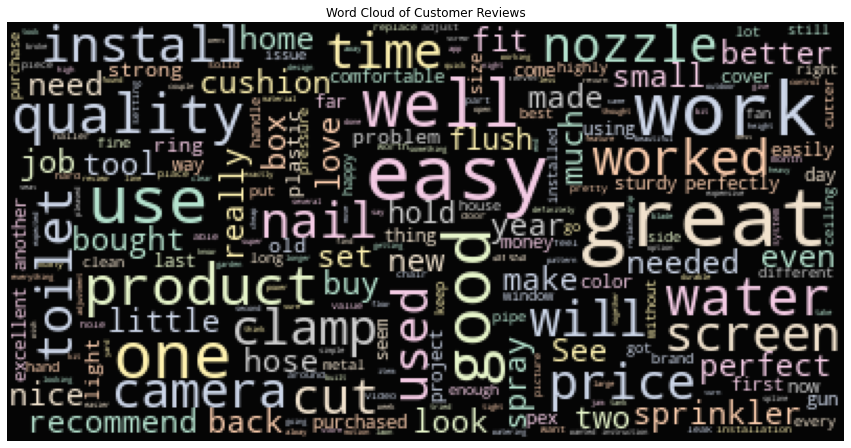

In [47]:
generate_wordclouds(cust_rev_df)

In [56]:
def gram_analysis(data,gram):
    stop_words_set = set(stopwords.words('english'))
    tokens=[t for t in data.lower().split(" ") if t!="" if t not in stop_words_set]
    ngrams=zip(*[tokens[i:] for i in range(gram)])
    final_tokens=[" ".join(z) for z in ngrams]
    return final_tokens

def gram_freq(df, gram, categ_col, text_col):
    review_text = " ".join(df[df[categ_col]==1][text_col].sample(200, replace=True).values)
    toks = gram_analysis(review_text, gram)
    tok_freq = pd.DataFrame(data=[toks, np.ones(len(toks))]).T.groupby(0).sum().reset_index()
    tok_freq.columns = ['token','frequency']
    tok_freq = tok_freq.sort_values(by='frequency',ascending=False)
    
    plt.figure(figsize=(10,8))
    plt.title(f"Most common tokens: {categ_col}")
    sns.barplot(x='token', y='frequency', data=tok_freq.iloc[:30])
    plt.xticks(rotation=90)
    plt.show()

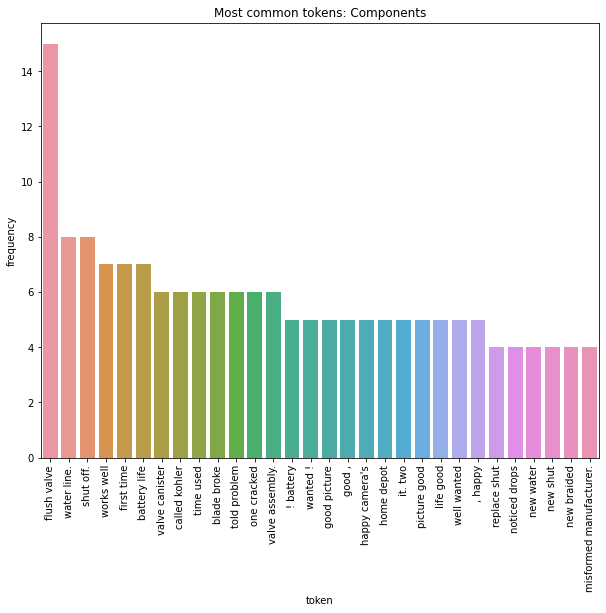

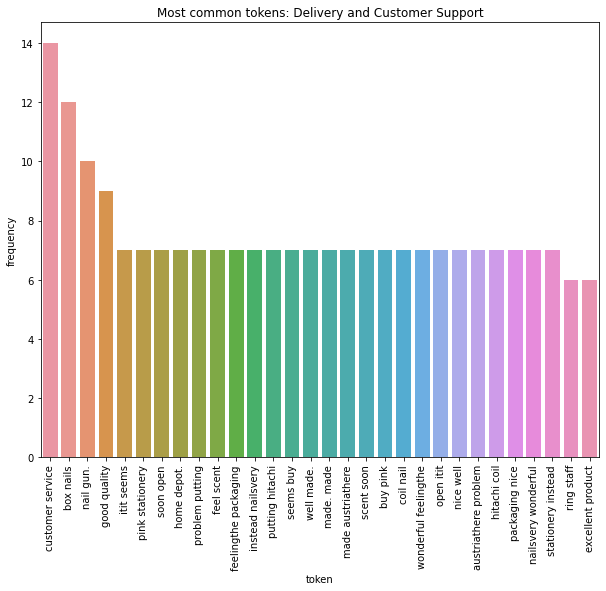

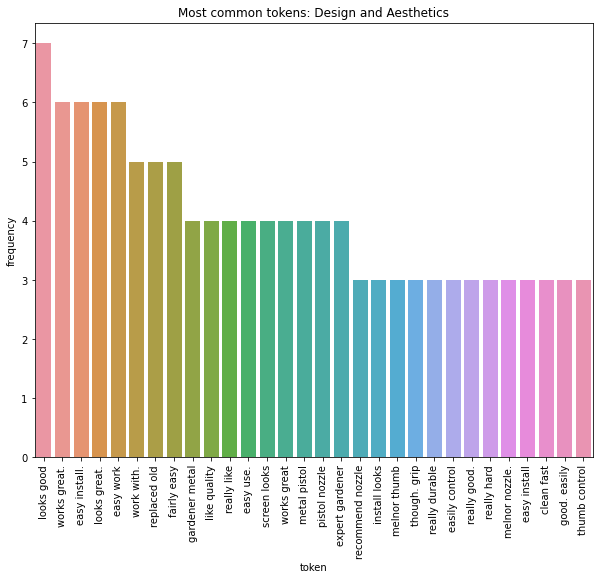

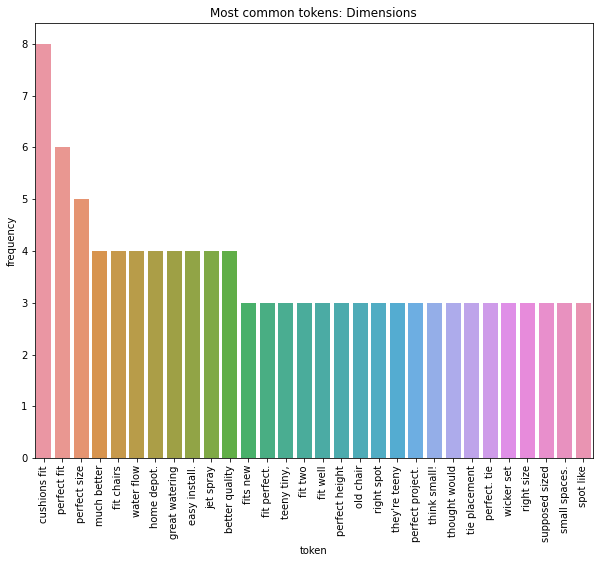

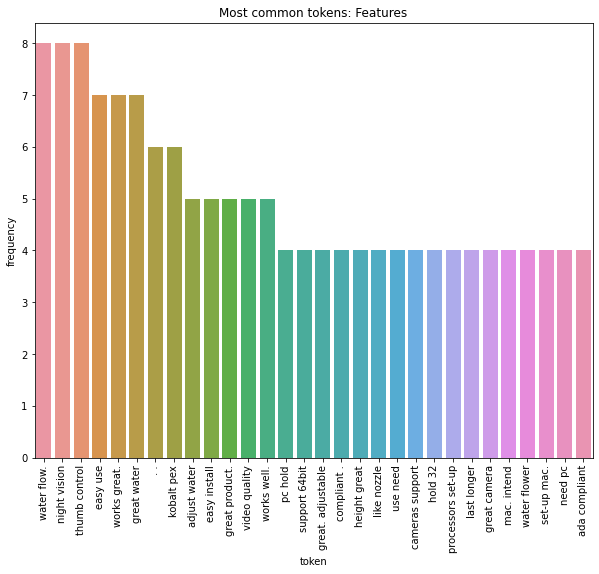

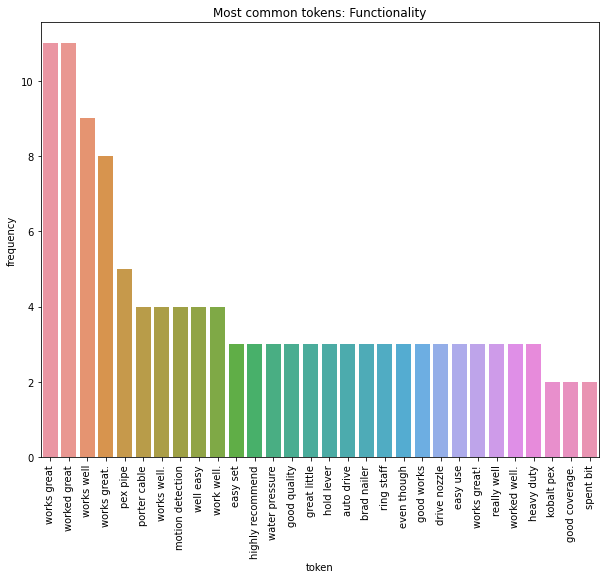

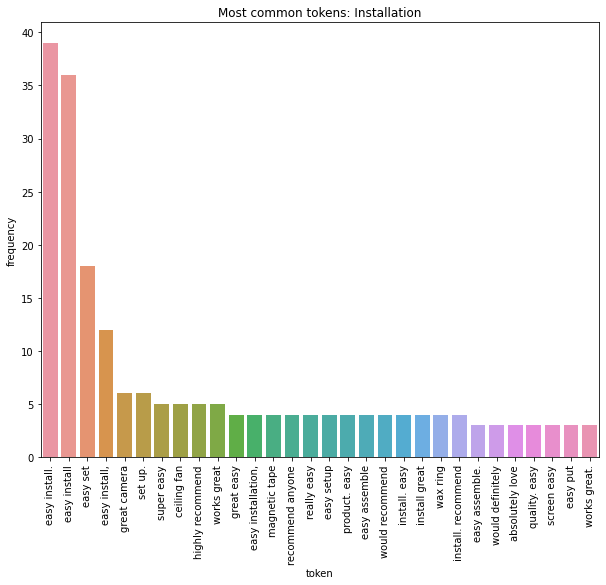

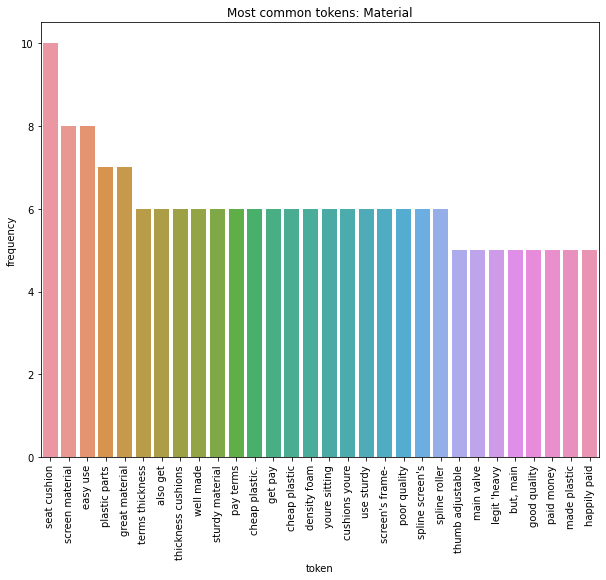

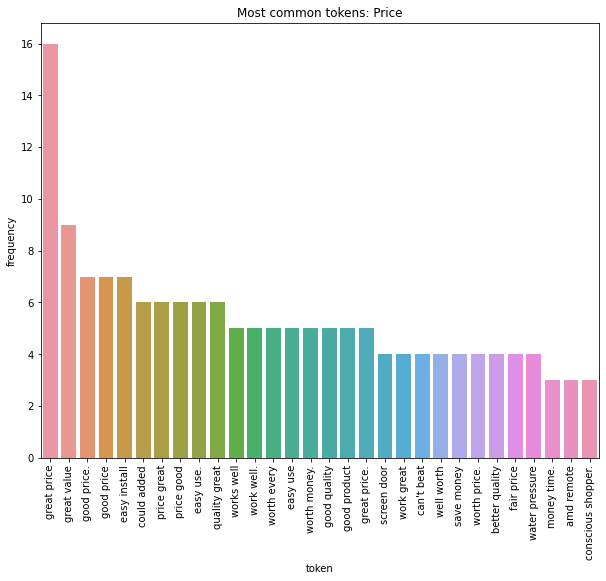

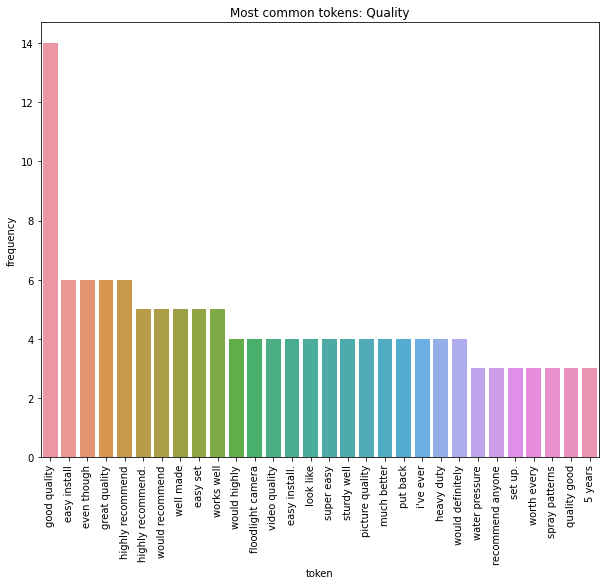

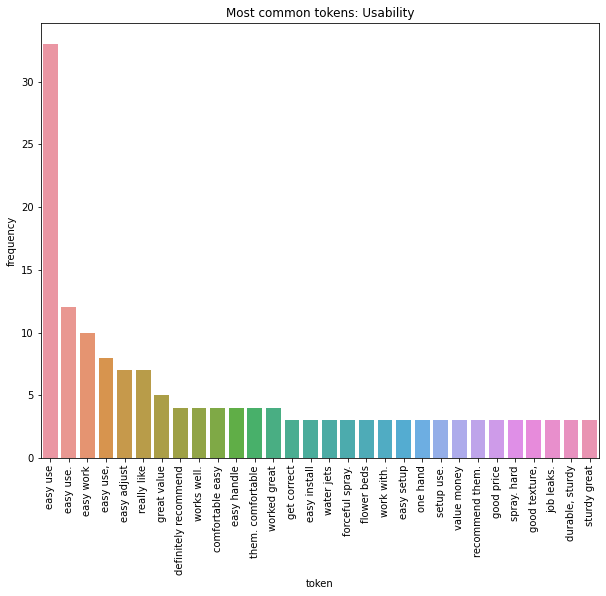

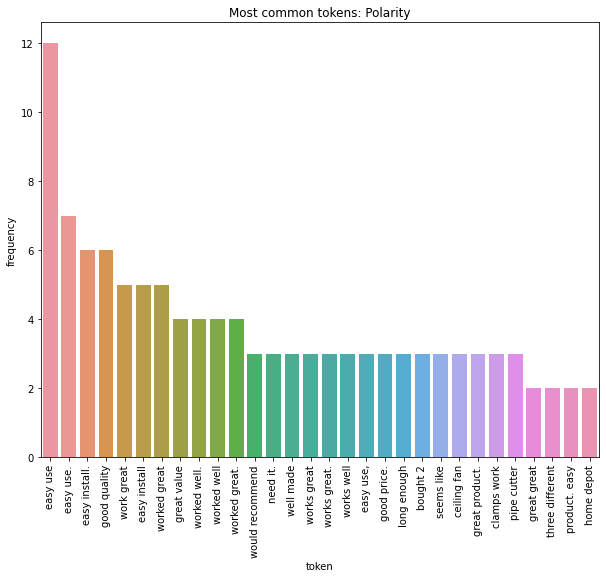

In [58]:
# Bi-Gram Analysis
for i in LABEL_COLUMNS:
    gram_freq(train_df,2, i, 'Review')

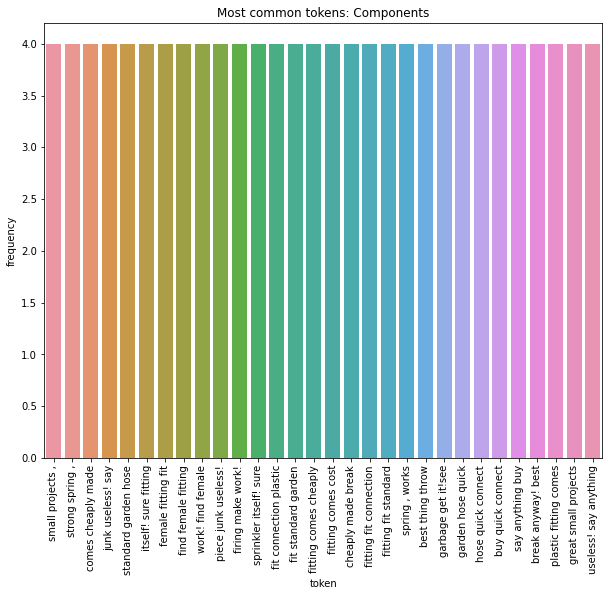

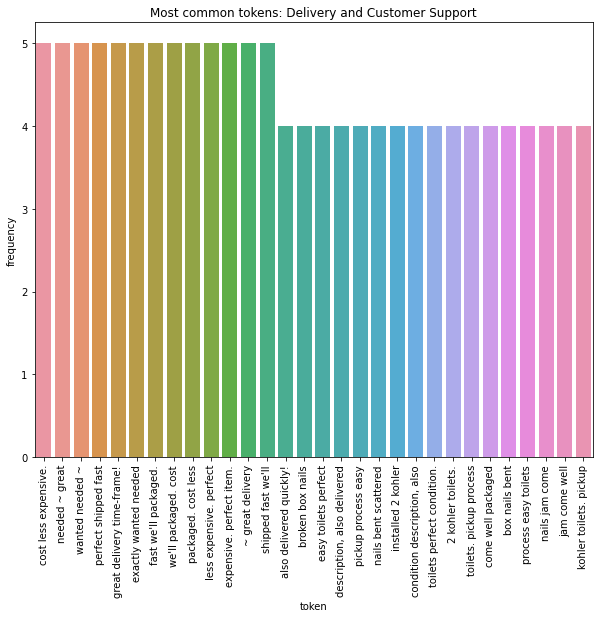

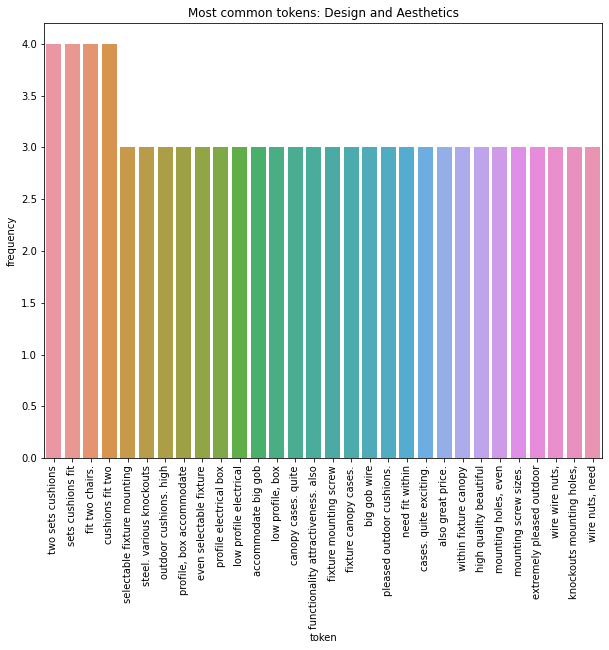

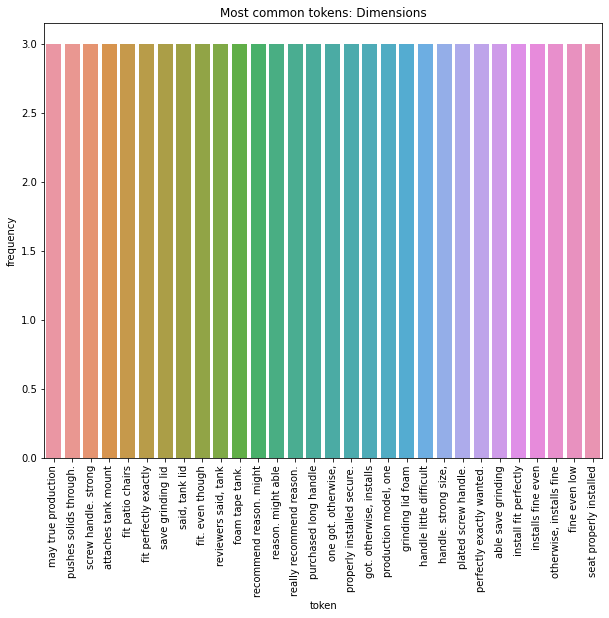

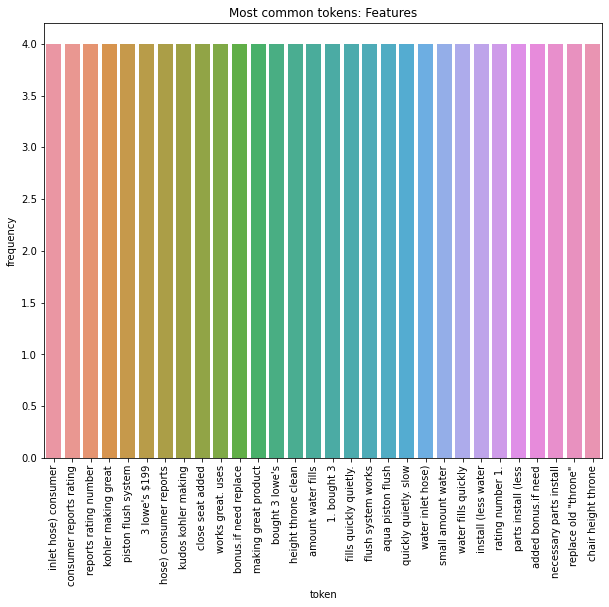

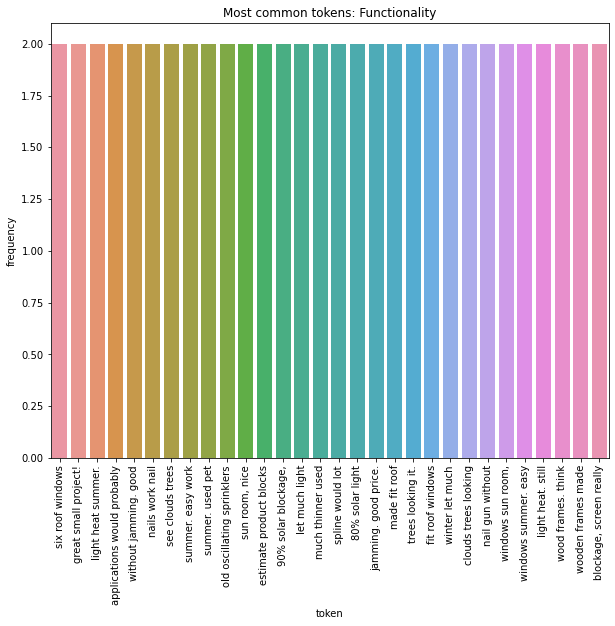

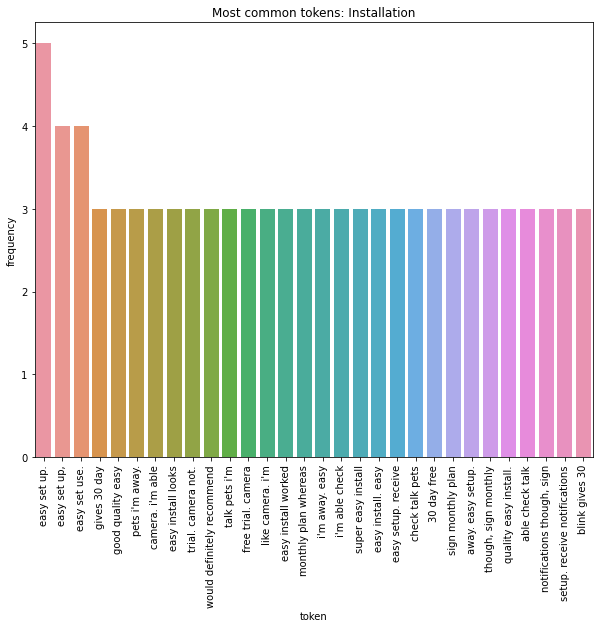

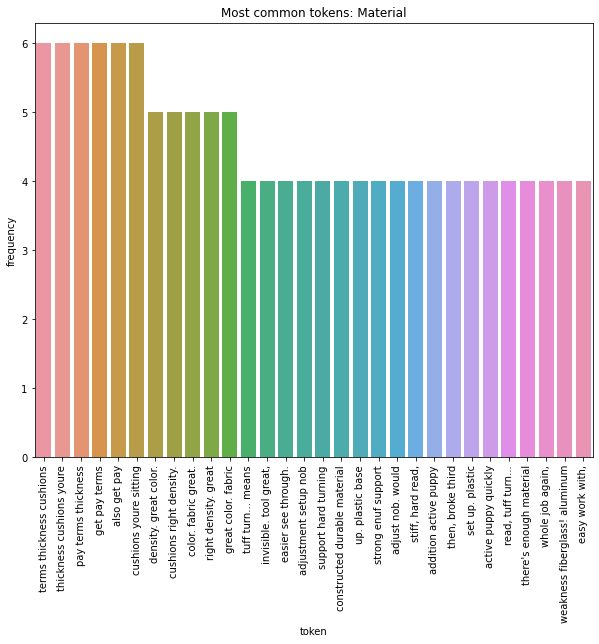

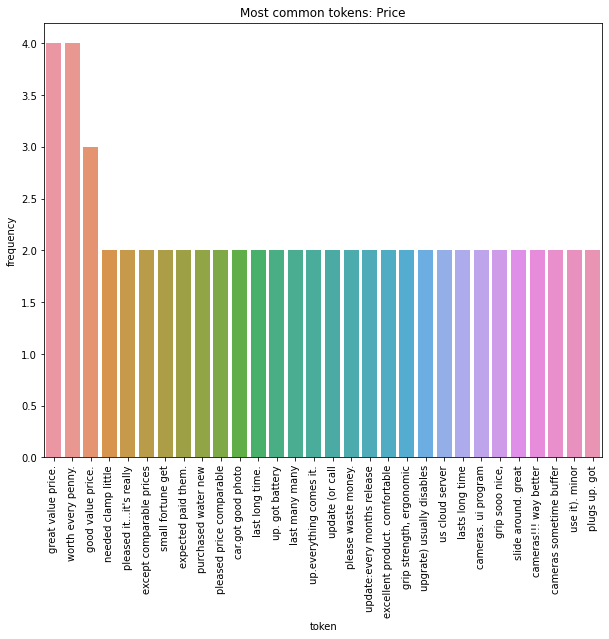

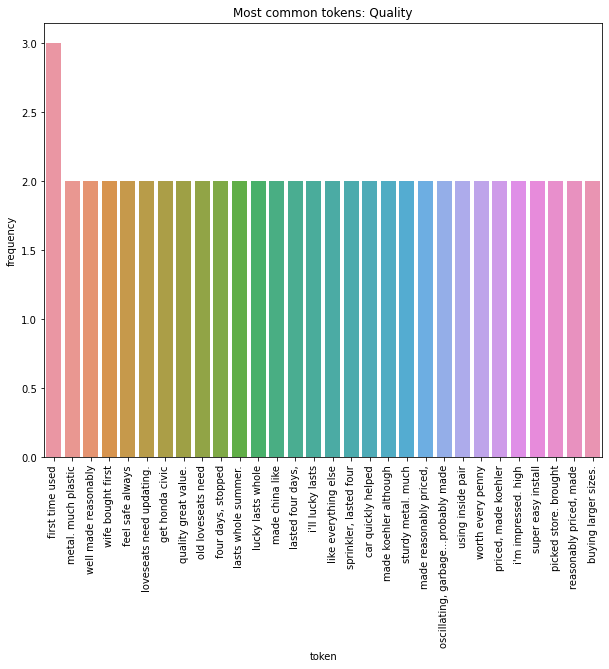

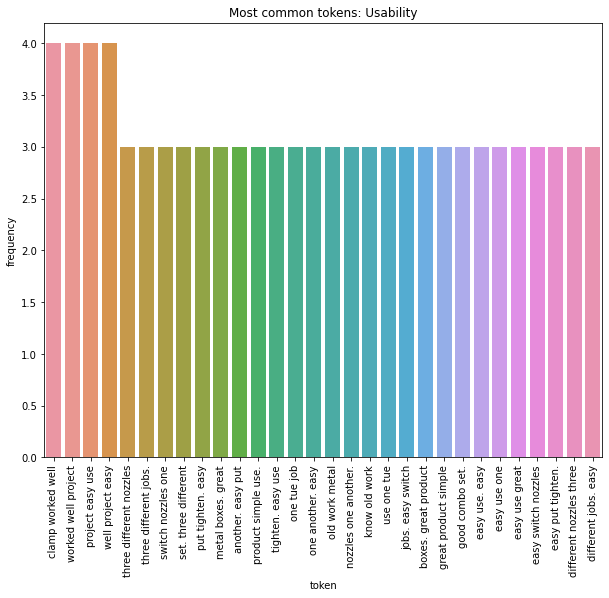

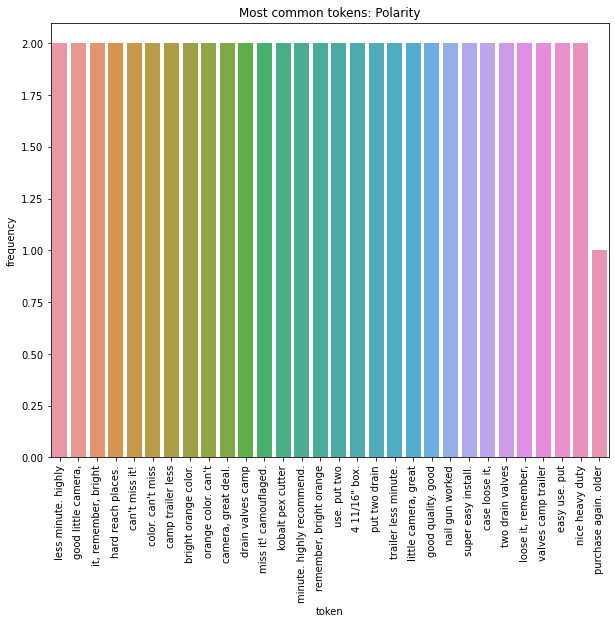

In [59]:
# Tri-gram analysis
for i in LABEL_COLUMNS:
    gram_freq(train_df,3, i, 'Review')

# Section 2: Multi-Label Text Classification using Classical Machine Learning Methods

## Preprocessing

- Expand Contractions
- Remove Punctuations
- 

In [37]:
!pip install --quiet contractions
import contractions

     |████████████████████████████████| 106 kB 11.8 MB/s 
     |████████████████████████████████| 284 kB 77.9 MB/s 


# Section 3: Multi-Label text Classification using **BERT(Bidirectional Encoder Representations from Transformers)** on raw data.

## About **BERT**

## Why Hugging Face? 🤗

- **HuggingFace** Ecosystem provides standardized interface to a wide range of transformers models.
- It provides task-specific heads which helps us to easily fine-tune transformers on downstream tasks.
- It also helps in experimenting with State-of-the-Art transformer model architectures easily.

## Why PyTorch Lightning? ⚡

- **PyTorch Lightning** is a PyTorch wrapper for high-performance AI research, scaling the models and disentangling PyTorch code to decouple the science from engineering.
- It basically structures PyTorch code with following principles:
  - Maximal Flexibility
  - No BoilerPlate
  - Self-contained Models
  - Modular 



# Install & Import Required Packages

In [58]:
!pip install --quiet transformers # Hugging Face Transformers
!pip install --quiet pytorch_lightning # PyTorch Lightning Framework

In [59]:
import transformers
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import seaborn as sns
from pylab import rcParams
import pandas as pd
import matplotlib.pyplot as plt
import random

In [60]:
%matplotlib inline
%config InlineBackend.figure_format="retina"
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
rcParams["figure.figsize"] = 16, 10

In [65]:
train_df[LABEL_COLUMNS].sum()

Components                        249
Delivery and Customer Support     161
Design and Aesthetics             599
Dimensions                        634
Features                          277
Functionality                    2288
Installation                      678
Material                          140
Price                             759
Quality                          1972
Usability                        1111
Polarity                         4301
dtype: int64

In [66]:
# Check random sample review to get idea of reviews
sample_row = cust_rev_df.iloc[random.randint(0, len(cust_rev_df))]
sample_review = sample_row.Review
sample_labels = sample_row[LABEL_COLUMNS]
print(f"{sample_review}\n{sample_labels.to_dict()}")

Very easy to use and handle
{'Components': 0, 'Delivery and Customer Support': 0, 'Design and Aesthetics': 0, 'Dimensions': 0, 'Features': 0, 'Functionality': 0, 'Installation': 0, 'Material': 0, 'Price': 0, 'Quality': 0, 'Usability': 1, 'Polarity': 1}


In [67]:
# Using BERT pretrained Tokenizer
BERT_MODEL_NAME = "bert-base-cased"
tokenizer = transformers.BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [68]:
# Check the tokens for a sample review using BERT pre-trained Tokenizer
encoding = tokenizer.encode_plus(
    sample_review, 
    add_special_tokens=True, 
    max_length=512, 
    return_token_type_ids=False, 
    padding="max_length", 
    return_attention_mask=True, 
    return_tensors="pt"
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [69]:
# Let's check the shape
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [82]:
class CustomerReviewDataset(Dataset):
  
  def __init__(self, 
               data: pd.DataFrame, 
               tokenizer: transformers.BertTokenizer, 
               max_token_len: int = 128):
    self.data = data
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, 
                  index: int):
    data_row = self.data.iloc[index]
    review_text = data_row.Review, 
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
        review_text, 
        add_special_tokens=True, 
        max_length=self.max_token_len, 
        return_token_type_ids=False, 
        padding="max_length", 
        truncation=True, 
        return_attention_mask=True, 
        return_tensors="pt"
    )
    return dict(
        input_ids=encoding["input_ids"].flatten(), 
        attention_mask=encoding["attention_mask"].flatten(), 
        labels=torch.FloatTensor(labels)
    )

In [83]:
train_dataset = CustomerReviewDataset(train_df, tokenizer)

In [84]:
sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [85]:
sample_item["input_ids"].shape, sample_item["attention_mask"].shape, sample_item["labels"].shape

(torch.Size([128]), torch.Size([128]), torch.Size([12]))

In [86]:
bert_model = transformers.BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [87]:
# As BERT expects batch of input,
# unsqueeze operation is needed for our sample_item
# to add an extra dimension representing a dummy batch_size
prediction = bert_model(
    sample_item["input_ids"].unsqueeze(dim=0), 
    sample_item["attention_mask"].unsqueeze(dim=0)   
)
prediction.last_hidden_state.shape

torch.Size([1, 128, 768])

In [88]:
class CustomerReviewDataModule(pl.LightningDataModule):

  def __init__(self, 
               train_df, 
               val_df, 
               test_df, 
               tokenizer, 
               batch_size=8, 
               max_token_len=128):
    super().__init__()
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.batch_size = batch_size
    self.max_token_len = max_token_len

  def setup(self):
    self.train_dataset = CustomerReviewDataset(
        self.train_df, 
        self.tokenizer, 
        self.max_token_len
    )
    self.val_dataset = CustomerReviewDataset(
        self.val_df, 
        self.tokenizer, 
        self.max_token_len
    )
    self.test_dataset = CustomerReviewDataset(
        self.test_df, 
        self.tokenizer, 
        self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
        self.train_dataset, 
        batch_size=self.batch_size, 
        shuffle=True, 
        num_workers=4
    )

  def val_dataloader(self):
    return DataLoader(
        self.val_dataset, 
        batch_size=1, 
        num_workers=4
    )

  def val_dataloader(self):
    return DataLoader(
        self.test_dataset, 
        batch_size=1, 
        num_workers=4
    )

In [89]:
N_EPOCHS = 10
BATCH_SIZE = 8
data_module = CustomerReviewDataModule(train_df, 
                                       val_df, 
                                       test_df, 
                                       tokenizer, 
                                       batch_size=BATCH_SIZE)
data_module.setup()

### Modeling

- Using BCELoss

In [102]:
from torchmetrics import AUROC
from transformers.optimization import get_linear_schedule_with_warmup
auroc = AUROC(num_classes=12)
class CustomerReviewClassifier(pl.LightningModule):
  def __init__(self, 
               n_classes: int, 
               steps_per_epoch=None, 
               n_epochs=None):
    super().__init__()
    self.bert = transformers.BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.steps_per_epoch = steps_per_epoch
    self.n_epochs = n_epochs
    self.criterion = nn.BCELoss()

  def forward(self, 
              input_ids, 
              attention_mask, 
              labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, output = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": output, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, output = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, output = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):

    labels = []
    predictions = []

    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)

      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      roc_score = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", roc_score, self.current_epoch)

  def configure_optimizers(self):

    optimizer = transformers.AdamW(self.parameters(), lr=2e-5)
    warmup_steps = self.steps_per_epoch // 3
    total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        warmup_steps, 
        total_steps
    )
    return [optimizer], [scheduler]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [103]:
model = CustomerReviewClassifier(
    n_classes=12, 
    steps_per_epoch=len(train_df) // BATCH_SIZE, 
    n_epochs=N_EPOCHS
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [104]:
trainer = pl.Trainer(max_epochs=N_EPOCHS, 
                     gpus=1, 
                     progress_bar_refresh_rate=30)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [105]:
trainer.fit(model, data_module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 9.2 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.278 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'labels', 'predictions'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

0
tensor(0.5064)
1
tensor(0.4510)
2
tensor(0.5148)
3
tensor(0.5154)
4
tensor(0.4944)
5
tensor(0.5068)
6
tensor(0.4727)
7
tensor(0.5230)
8
tensor(0.4981)
9
tensor(0.5028)
10
tensor(0.4856)
11
tensor(0.4798)


Validating: 0it [00:00, ?it/s]

0
tensor(0.5196)
1
tensor(0.4907)
2
tensor(0.4973)
3
tensor(0.4995)
4
tensor(0.5077)
5
tensor(0.5026)
6
tensor(0.4954)
7
tensor(0.5177)
8
tensor(0.4983)
9
tensor(0.5101)
10
tensor(0.5033)
11
tensor(0.5054)


Validating: 0it [00:00, ?it/s]

0
tensor(0.5031)
1
tensor(0.5100)
2
tensor(0.4894)
3
tensor(0.4872)
4
tensor(0.4746)
5
tensor(0.4857)
6
tensor(0.4996)
7
tensor(0.4729)
8
tensor(0.4881)
9
tensor(0.5107)
10
tensor(0.4934)
11
tensor(0.4846)


Validating: 0it [00:00, ?it/s]

0
tensor(0.4597)
1
tensor(0.4729)
2
tensor(0.5302)
3
tensor(0.5210)
4
tensor(0.5311)
5
tensor(0.5007)
6
tensor(0.5345)
7
tensor(0.4961)
8
tensor(0.5040)
9
tensor(0.5005)
10
tensor(0.5034)
11
tensor(0.5033)


Validating: 0it [00:00, ?it/s]

0
tensor(0.4980)
1
tensor(0.5039)
2
tensor(0.4861)
3
tensor(0.5058)
4
tensor(0.5006)
5
tensor(0.4942)
6
tensor(0.4800)
7
tensor(0.5222)
8
tensor(0.4980)
9
tensor(0.5103)
10
tensor(0.4972)
11
tensor(0.5076)


Validating: 0it [00:00, ?it/s]

0
tensor(0.5128)
1
tensor(0.5148)
2
tensor(0.5090)
3
tensor(0.4980)
4
tensor(0.5178)
5
tensor(0.5008)
6
tensor(0.4879)
7
tensor(0.5038)
8
tensor(0.5031)
9
tensor(0.4891)
10
tensor(0.4937)
11
tensor(0.5149)


Validating: 0it [00:00, ?it/s]

0
tensor(0.4748)
1
tensor(0.4811)
2
tensor(0.4973)
3
tensor(0.4959)
4
tensor(0.4827)
5
tensor(0.4872)
6
tensor(0.5028)
7
tensor(0.4683)
8
tensor(0.5074)
9
tensor(0.5072)
10
tensor(0.4984)
11
tensor(0.4965)


Validating: 0it [00:00, ?it/s]

0
tensor(0.5115)
1
tensor(0.4823)
2
tensor(0.4896)
3
tensor(0.5020)
4
tensor(0.4634)
5
tensor(0.5012)
6
tensor(0.4898)
7
tensor(0.5032)
8
tensor(0.5012)
9
tensor(0.5024)
10
tensor(0.5083)
11
tensor(0.4933)


Validating: 0it [00:00, ?it/s]

0
tensor(0.4815)
1
tensor(0.4720)
2
tensor(0.4848)
3
tensor(0.5044)
4
tensor(0.5150)
5
tensor(0.5054)
6
tensor(0.4891)
7
tensor(0.4926)
8
tensor(0.4943)
9
tensor(0.5137)
10
tensor(0.4884)
11
tensor(0.4952)


Validating: 0it [00:00, ?it/s]

0
tensor(0.4976)
1
tensor(0.5384)
2
tensor(0.4802)
3
tensor(0.4889)
4
tensor(0.4993)
5
tensor(0.5002)
6
tensor(0.5010)
7
tensor(0.4724)
8
tensor(0.5029)
9
tensor(0.4948)
10
tensor(0.5069)
11
tensor(0.5052)


In [ ]:
 %load_ext tensorboard
 %tensorboard --logdir ./lightning_logs